Importation de Modules utiles et définitions de certains termes.

In [ ]:
from scipy.constants import Avogadro, c, m_e, m_p, e, physical_constants

from functools import partial, lru_cache
import csv
import scipy.integrate as integrate
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt     #Permet de générer des graphiques.

eV_to_MeV = 1e-6            #Convertion eV vers MeV.

m_p = m_p  * eV_to_MeV/e    # Masse du proton en MeV/c^2
m_e = m_e  * eV_to_MeV/e    # Masse de l'électron en MeV/c^2

r_e = physical_constants["classical electron radius"][0] * 1e2      # cm

# Q1
Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD--------------

In [ ]:
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

I_bone = 91.9 * eV_to_MeV                                                                                               # Mean Excitation Energy en MeV de l'eau liquide.
rho_bone = 1.85                                                                                                         # Densité de l'os Compact en g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])                                                            # Nombre atomique.
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])   # Fractions Massiques.
AtomicMasses_bone = np.array([1.007975, 12.0106, 14.006855, 15.99940, 24.3055, 30.973762, 32.0675, 40.078])             # Masses Atomiques.

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, AtomicMasses_bone)                              # Densité électronique de l'Os Compact

I_water = 75 * eV_to_MeV                                                                                                # Mean Excitation Energy en MeV de l'eau liquide.
rho_water = 1                                                                                                           # Densité de l'eau liquide en g/cm^3
atomic_numbers_water = np.array([1, 8])                                                                                 # Nombre atomique.
fractions_by_weight_water = np.array([0.111894, 0.888106])                                                              # Fractions Massiques.
AtomicMasses_water = np.array([1.008, 15.999])                                                                          # Masses Atomiques.

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, AtomicMasses_water)                         # Densité électronique de l'eau liquide

print(f"Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de {n_e_bone} e-/cm\u00b3 et {n_e_water} e-/cm\u00b3.")

# Q2

Tracez les courbes du pouvoir d’arrêt collisionnel massique pour ces milieux en fonction de l’énergie cinétique (T). Pour expliciter la dépendance en T de Scol, utilisez les relations 9 et 10 ci-bas. Pour le graphique, utilisez une échelle logarithmique en abscisse. Vous trouverez les énergies moyennes d’excitation I de ces matériaux sur le site du NIST également. L’approximation d’une décélération continue (Continuous Slowing Down Approximation, CSDA) des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu sont considérés.

Équation 9 :
$$
T = (\gamma - 1) m_p c^2 \Rightarrow \gamma = \frac{T}{m_p c^2} + 1
$$
Équation 10 :
$$
\gamma = \frac{1}{\sqrt{1 - \beta^2}} \Rightarrow \gamma^2 \beta^2 = (\gamma^2 - 1)
$$


Certaines Équations sont utiles afin de faire ce problème :

Équation 3:
$$
T_e^{max} = \frac{2 m_e c^2 (\gamma^2 - 1)}{1 + 2 \gamma \frac{m_e}{m_p} + \left( \frac{m_e}{m_p} \right)^2}
$$
Équation 4:
$$
S_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \big[\ln\big(\frac{2 m_e c^2 \beta^2 \lambda^2 T_e^{max}}{I^2}\big) - 2 \beta^2\big]
$$
-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD-------------

In [ ]:
def gamma(T):   # Implémentation de l'équation 9.
    gamma = T/(m_p*c**2) + 1
    return gamma

def beta(T):    # implémentation de l'équation 10.
    beta = np.sqrt((gamma(T)**2 - 1)/gamma(T)**2)
    return beta

def t_max(T):   # implémentation de l'équation 3.
    t_max = (2*m_e*c**2 * (gamma(T)**2 - 1))/(1 + 2*(m_e/m_p)*gamma(T) + (m_e/m_p)**2)
    return t_max

def s_col(T, n_e, I_MeV):   # implémentation de l'équation 4.
    constant = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    s_col = constant * (1/beta(T)**2) * (np.log(2*m_e*c**2*beta(T)**2*t_max(T)/I_MeV**2) - 2*beta(T)**2)
    return s_col

SCol_bone = partial(s_col, n_e=n_e_bone, I_MeV=I_bone)      # définition du pouvoir d'arrêt collisionnel pour l'os compact.

SCol_water = partial(s_col, n_e=n_e_water, I_MeV=I_water)   # définition du pouvoir d'arrêt collisionnel pour l'eau liquide.

T = np.linspace(3, 250, 248)
S_col_water = SCol_water(T)     # Calcul du pouvoir d'arrêt collisionnel pour l'eau liquide.
S_col_bone = SCol_bone(T)       # Calcul du pouvoir d'arrêt collisionnel pour l'os compact.

print(f"Kinetic energy T: {T}")
print(f"Stopping Power S_col_bone: {S_col_bone} MeV/cm")
print(f"Stopping Power S_col_water: {S_col_water} MeV/cm")

# %%
def plotit(T, bone=S_col_bone, water=S_col_water):      # Mise en graphique des pouvoirs d'arrêts.
    plt.plot(T, water, label="Eau")  # Tracé normal (pas semi-log sur X)
    plt.plot(T, bone, label="Os Compacte")
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
    plt.xscale('log')  # Axe des y en échelle logarithmique
    plt.legend()
    plt.grid()
    plt.show()

plotit(T)

# Q3


Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.


Pour l'eau liquide:

In [ ]:
Ke_Mev_eau_liquide, \
Stopping_power_Electronic_eau_liquide, \
Stopping_power_Nuclear_eau_liquide, \
Stopping_power_total_eau_liquide = np.loadtxt("data_eau_liquide.txt", unpack=True)

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide,'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Totale")
plt.legend()
plt.show()

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, 'r-',label="Totale")
plt.legend()

plt.show()


Nous pouvons voir qu'il n'est pas nécessaire de considérer l'effet atomique. En effet, sa contribution est très minime. Le premier graph montre les contribution de toutes les parties alors que le deuxième graph montre le stopping power total et électronique.

Pour l'os compact:

In [ ]:

Ke_Mev_os_compact , \
Stopping_power_Electronic_os_compact, \
Stopping_power_Nuclear_os_compact, \
Stopping_power_total_os_compact = np.loadtxt("data_os_compact.txt", unpack=True)

plt.title("Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact,'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Totale")
plt.legend()
plt.show()
plt.title("Os compacte")

plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, 'r-',label="Totale")
plt.legend()

plt.show()

# Q4

À partir de l'équation suivante $ \frac{S_{col}}{\rho} = - \left( \frac{1}{\rho} \frac{dT}{dx} \right)_{col} $ on peut réexprimer dx en fonction du reste. $$ dx = -\frac{dT}{S_{col}} $$ On obtient ensuite $$ x = -\int^{T_i}_0 \frac{dT}{S_{col}}$$

En prenant l'inverse du pouvoir d'arrêt, cela nous permet d'avoir les unités de longueurs par rapport de l'énergie. On intègre ensuite sur ces unités de longueurs pour obtenir l'entièreté de la porté.


In [ ]:
def inverse(func):
    def wrapper(*args):
        res = func(*args)
        return 1/res
    return wrapper
    

# Q5 

## À améliorer:
Équation complexe, il n’existe pas de solution analytique générale permettant de relier directement l’énergie initiale d’un proton à sa portée dans un milieu donné. $\frac{1}{\ln(x)}$ ne s'intègre pas.

# Q6

In [ ]:
@lru_cache(maxsize=None)
def inverse_scol_water(T):  #Inverse de Scol
    return 1/SCol_water(T)

@lru_cache(maxsize=None)
def inverse_scol_bone(T):
    return 1/SCol_bone(T)

def n_valeurs():
    puissance_de_2 = [2**i for i in range(1, 27)]
    return puissance_de_2

def trapeze_adaptatif_n_valeurs(water_bone, a, b, n_valeurs, tol=np.finfo(float).eps):
    """
    Méthode des trapèzes adaptative pour l'intégration numérique avec une liste de valeurs de N.
    Stocke les résultats dans trois listes distinctes pour analyse ultérieure.

    Args:
        water_bone: La fonction à intégrer.
        a, b: Borne inférieure et supérieure de l'intégrale.
        n_valeurs: Liste de valeurs de N (nombre de tranches pour chaque calcul).
        tol: Tolérance (précision machine par défaut).

    Returns:
        (I_final, n_list, i_list, error_list): Calcul final de l'intégrale et trois listes contenant respectivement
             les valeurs de N, les approximations successives et les erreurs associées.
    """
    # Initialisation des listes pour stocker les résultats
    n_list = []  # Liste des valeurs de N
    i_list = []  # Liste des valeurs d'I (approximations successives)
    error_list = []  # Liste des erreurs entre I_i et I_{i-1}

    I_prev = None  # Initialisation de la variable pour stocker les résultats précédents

    for N in n_valeurs:  # Parcourir les valeurs de N
        h = (b - a) / N

        # Calcul initial
        s = 0.5 * water_bone(a) + 0.5 * water_bone(b)
        for items in range(1, N):  # Ajouter les termes intermédiaires
            s += water_bone(a + items * h)

        # Calcul de l'intégrale pour cette valeur de N
        I_current = h * s

        # Ajouter la valeur actuelle de N et de l'intégrale calculée
        n_list.append(N)
        i_list.append(I_current)

        # Si ce n'est pas la première estimation, calculons l'erreur
        if I_prev is not None:
            erreur = abs(I_current - I_prev) / 3  # Erreur entre deux étapes consécutives
            error_list.append(erreur)  # Ajouter l'erreur dans la liste

            print(f"N = {N}, I = {I_current}, Erreur = {erreur}")

            # Comparer avec la tolérance
            if erreur < tol:
                print(f"Convergence atteinte avec N = {N}, I = {I_current}")
                return I_current, n_list, i_list, error_list
        else:
            # Ajouter une erreur vide (pas d'erreur calculée pour la première estimation)
            error_list.append(None)

        # Mise à jour pour l'estimation suivante
        I_prev = I_current

    return I_current, n_list, i_list, error_list

In [ ]:
I_final, n_list, i_list, error_list = trapeze_adaptatif_n_valeurs(inverse_scol_water, 3, 150, n_valeurs())

with open("resultats_water.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["N", "I (Estimation)", "Erreur"])
    for n, i, error in zip(n_list, i_list, error_list):
        writer.writerow([n, i, error])

In [ ]:
I_final, n_list, i_list, error_list = trapeze_adaptatif_n_valeurs(inverse_scol_bone, 3, 150, n_valeurs())

with open("resultats_bone.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["N", "I (Estimation)", "Erreur"])
    for n, i, error in zip(n_list, i_list, error_list):
        writer.writerow([n, i, error])

# Q7
Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.

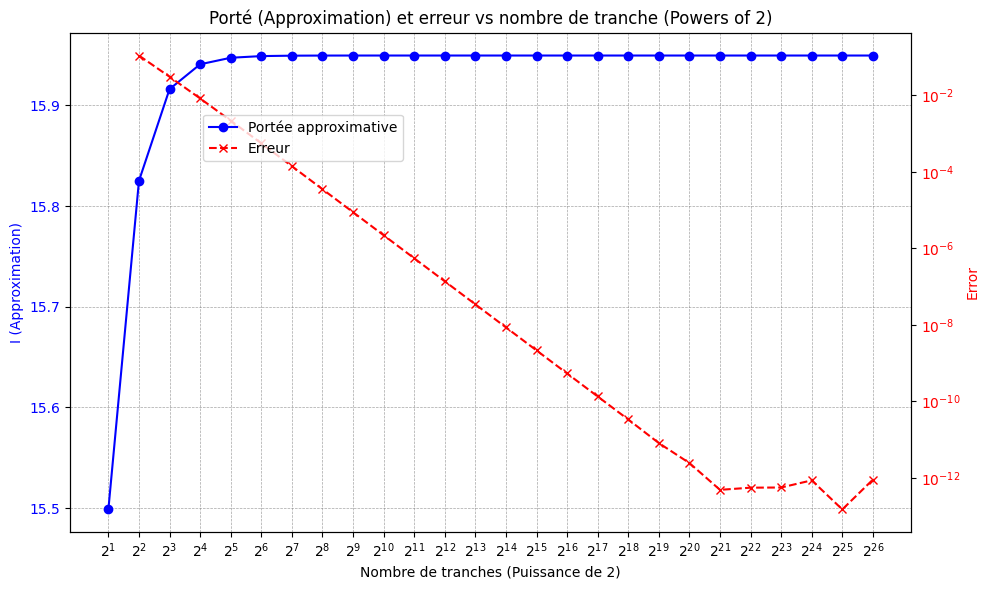

In [17]:
data_eau = pd.read_csv("resultats_water.csv")

N = data_eau["N"]

I_eau = data_eau["I (Estimation)"]
erreur_eau = data_eau["Erreur"]

# Step 2: Create the figure and the first Y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="blue")  # y-axis de gauche

ax1.plot(N, I_eau, label="Portée approximative", marker="o", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)  # Add grid for better visualization

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="red")  # y-axis de droite
ax2.plot(N, erreur_eau, label="Erreur", marker="x", linestyle="--", color="red")
ax2.set_yscale('log')
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (Powers of 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

# Step 5: Add legends
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85), bbox_transform=ax1.transAxes)

plt.show()


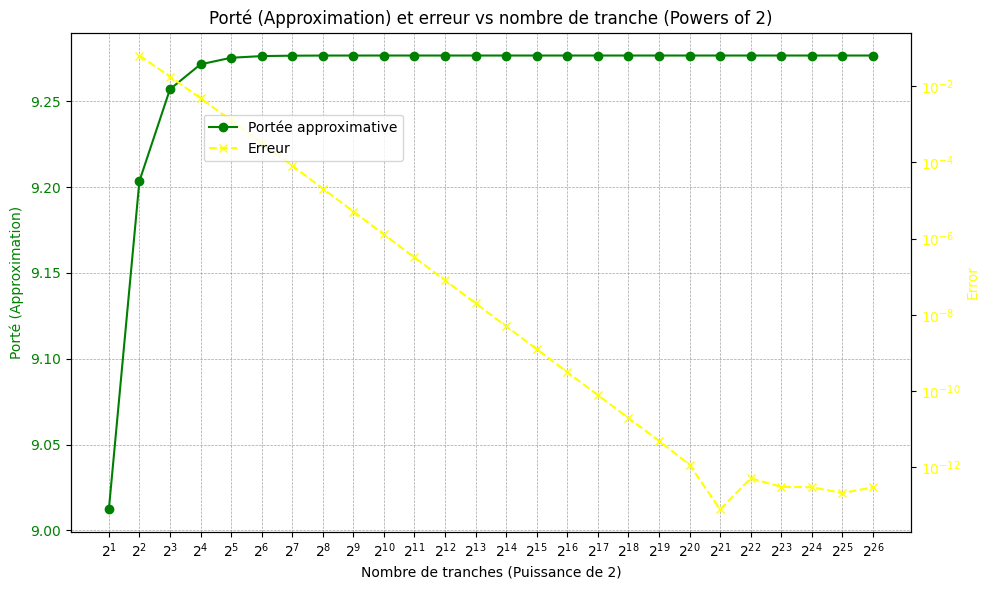

In [21]:
data_bone = pd.read_csv("resultats_bone.csv")

N = data_bone["N"]

I_bone = data_bone["I (Estimation)"]
erreur_bone = data_bone["Erreur"]

# Step 2: Create the figure and the first Y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="green")  # y-axis de gauche

ax1.plot(N, I_bone, label="Portée approximative", marker="o", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)  # Add grid for better visualization

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="yellow")  # y-axis de droite
ax2.plot(N, erreur_bone, label="Erreur", marker="x", linestyle="--", color="yellow")
ax2.set_yscale('log')
ax2.tick_params(axis="y", labelcolor="yellow")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (Powers of 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

# Step 5: Add legends
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85), bbox_transform=ax1.transAxes)

plt.show()

## Q8
la dérivé de $ S^{-1}_{col}$, selon mon calcul à la main est : $$  \frac{d S^{-1}_{col}}{dT} = \frac{-1}{2\pi r_e^2 m_e c^4 n_e m_p } 
\left( \frac{\left(\frac{-2\gamma^3}{(\gamma^2 - 1)^2} + \frac{2\gamma}{\gamma^2 -1}\right) 
\ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) + \frac{1}{\gamma^2 -1} \left( 4\gamma -\frac{\delta}{b+\delta \gamma}\right) }{\left[ \ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) \frac{\gamma^2}{\gamma^2 -1} -2\right]^2}\right)$$

In [ ]:
T = sp.Symbol('T', real=True, positive=True)  # Temperature
ne = sp.Symbol('n_e', real=True, positive=True)  # Electron number density
IMeV = sp.Symbol('I_{MeV}', real=True, positive=True)  # Ionization energy in MeV
re = sp.Symbol('r_e', real=True, positive=True)  # Classical electron radius
me = sp.Symbol('m_e', real=True, positive=True)  # Electron mass
mp = sp.Symbol('m_p', real=True, positive=True)  # Proton mass
c = sp.Symbol('c', real=True, positive=True)  # Speed of light

# Define gamma factor
gamma = T / (mp * c**2) + 1

# Define T_max
T_max = (2 * me * c**2 * (gamma**2 - 1)) / (1 + 2 * (me / mp) * gamma + (me / mp)**2)

# Define beta
beta = 1 / (gamma**2 / (gamma**2 - 1))

# Define U
U = 2 * sp.pi * re**2 * me * c**2 * ne

# Define S_col expression
S_col = U / (beta**2) * (sp.log((2 * me * c**2 * beta**2 * gamma**2 * T_max) / IMeV**2) - 2 * beta**2)

# Display the expression


In [ ]:
f = S_col**-1

In [ ]:
f = sp.simplify(f)

In [ ]:
dfdT = sp.diff(f,T)

In [ ]:
dfdT = sp.together(dfdT)

## Question 9

# **Optimisation**
## Question 10

In [ ]:
import scipy.stats

energy_proton = scipy.stats.moyal.rvs(loc=150, scale=4, size=10000)

plt.hist(energy_proton, bins=100)
plt.show()


## Question 11

In [ ]:
import timeit




In [ ]:
Romberg(inverse(SCol_water), 3, 150)